# Amazon Reviews Sentiment Analysis

In [1]:
import numpy as np
import pandas as pd

In [2]:
# Importing the Data
%cd ..
df = pd.read_csv("Data/aws_reviews_1000_2015_electronic.csv")
df = df[['review_body', 'star_rating']]
df.head()

C:\Users\PC Daryl\OneDrive - University of Arkansas\UARK\Spring 2022\ECON 5763 - Economic Analytics\MSEACapstone


,review_body,star_rating
0,love it,5
1,Works great!,4
2,Gave this as a gift and the recipient was thri...,5
3,It's a good beginners stereo. I bought it for ...,4
4,The connection on my iHOME cube was beginning ...,5


Tentatively, I will classify reviews that scored 3 and above as positive and the rest as negative.

In [3]:
# Creating Sentiment Column
df['sentiment'] = df['star_rating'].apply(lambda x: 'positive' if x>=3 else 'negative')
df.head()

,review_body,star_rating,sentiment
0,love it,5,positive
1,Works great!,4,positive
2,Gave this as a gift and the recipient was thri...,5,positive
3,It's a good beginners stereo. I bought it for ...,4,positive
4,The connection on my iHOME cube was beginning ...,5,positive


### Text Preprocessing

Before we start building our model, we need to get rid of special characters, duplicates characters and standardize the formatting of the reviews. 

In [4]:
# Dependencies

if False: # Change it to true if you haven't installed it
    !pip install spacy==2.2.3
    !python -m spacy download en_core_web_sm
    !pip install beautifulsoup4==4.9.1
    !pip install textblob==0.15.3
    !pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git --upgrade --force-reinstall

In [5]:
import preprocess_kgptalkie as ps
import re

In [6]:
def get_clean(x):
    '''
    Reformat a string by removing duplicates, and special characters
    e.g: you're -> you are
         i'm -> i am
         I llllovvee iit!! -> i love it
         white_dog -> white dog
    '''
    x = str(x).lower().replace('\\', '').replace('_', ' ')
    x = ps.cont_exp(x) # you're -> you are; i'm -> i am
    x = ps.remove_emails(x)
    x = ps.remove_urls(x)
    x = ps.remove_html_tags(x)
    x = ps.remove_accented_chars(x)
    x = ps.remove_special_chars(x)
    x = re.sub("(.)\\1{2,}", "\\1", x) # (e.g: I llllovvee iit -> I love it)
    return x

In [7]:
df['review_body'] = df['review_body'].apply(lambda x: get_clean(x))

In [8]:
df.head()

,review_body,star_rating,sentiment
0,love it,5,positive
1,works great,4,positive
2,gave this as a gift and the recipient was thri...,5,positive
3,it is a good beginners stereo i bought it for ...,4,positive
4,the connection on my ihome cube was beginning ...,5,positive


### Model Building

We will use a Support Vector Machine

A support vector machine (SVM) is a supervised machine learning model that uses classification algorithms for two-group classification problems. After giving an SVM model sets of labeled training data for each category, they’re able to categorize new text.

The basics of Support Vector Machines and how it works are best understood with a simple example. Let’s imagine we have two tags: red and yellow, and our data has two features: x and y. We want a classifier that, given a pair of (x,y) coordinates, outputs if it’s either red or yellow. We plot our already labeled training data on a plane:

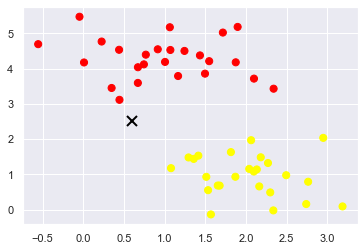

In [9]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline


X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

plt.plot([0.6], [2.5], 'x', color='black', markeredgewidth=2, markersize=10) # Unlabelled Point;

A support vector machine takes these data points and outputs the hyperplane (which in two dimensions it’s simply a line) that best separates the tags. This line is the decision boundary: anything that falls to one side of it we will classify as red, and anything that falls to the other as yellow.

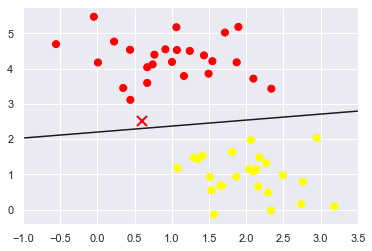

In [10]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.5], 'x', color='red', markeredgewidth=2, markersize=10) # Unlabelled Point


plt.plot(xfit, 0.17 * xfit + 2.2, '-k')

plt.xlim(-1, 3.5);

Now, we want to apply this algorithm for text classification, and the first thing we need is a way to transform a piece of text into a vector of numbers so we can run SVM with them. In other words, which features do we have to use in order to classify texts using SVM?

The most common answer is word frequencies

**TF-IDF (term frequency-inverse document frequency)** is a statistical measure that evaluates how relevant a word is to a document in a collection of documents.

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

In [12]:
# Tokenizing Raw text reviews
tfidf = TfidfVectorizer(max_features=5000)
X=df['review_body']
y=df['sentiment']
# y=df['star_rating']

X = tfidf.fit_transform(X)

In [13]:
X

<1000x4161 sparse matrix of type '<class 'numpy.float64'>'
	with 23505 stored elements in Compressed Sparse Row format>

In [14]:
print(X[:2,]) # Text Reviews got recoded in numbers

  (0, 1947)	0.4193551541780707
  (0, 2178)	0.9078222594011927
  (1, 1644)	0.6286022186765592
  (1, 4108)	0.7777269769494352


In [15]:
from random import sample, seed

seed(2022)
# Random Sample of features 
sample(tfidf.get_feature_names(), 10)

['mount',
 'teen',
 'opened',
 'blast',
 'somewhat',
 'ounce',
 '4th',
 'suburban',
 'one',
 'ton']

In [16]:
# Partion Data into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)

In [17]:
# Model
clf = LinearSVC(loss='hinge') # tweek parametters here to make it better (or worse)

# Training Model
clf.fit(X_train, y_train)

LinearSVC(loss='hinge')

In [18]:
# Testing Model
y_pred = clf.predict(X_test)

In [19]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.77      0.49      0.60        49
    positive       0.85      0.95      0.90       151

    accuracy                           0.84       200
   macro avg       0.81      0.72      0.75       200
weighted avg       0.83      0.84      0.83       200



### Testing the model on few reviews

In [20]:
# Let's understand how the algorith works
x = ['I love this phone, will definitely recommend',
     'This PHONE is terrible, I want a refund!', 
     'I believe this phone fulfill his purpose, but it could have been better']

for i in range(len(x)):
       x[i] = get_clean(x[i])
x

['i love this phone will definitely recommend',
 'this phone is terrible i want a refund',
 'i believe this phone fulfill his purpose but it could have been better']

In [21]:
vec = tfidf.transform(x) # tokenizing using previously created feature
vec

<3x4161 sparse matrix of type '<class 'numpy.float64'>'
	with 23 stored elements in Compressed Sparse Row format>

In [22]:
clf.predict(vec)

array(['positive', 'negative', 'positive'], dtype=object)

In [23]:
# Exporting the model
import pickle


pickle.dump(clf, open('amazon_svc', 'wb'))